In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# INSTALLING REQUIRED LIBRARIES
!pip install -U pyproj -q
!pip install -U utm -q
!pip install -U google-colab -q
!pip install -U tornado -q
!pip install geemap -q
!pip install wxee

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado==6.3.3, but you have tornado 6.4.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.1 MB/s eta 0:00:00


In [3]:
!pip install rioxarray
import xarray as xr
import rioxarray as rxr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# !earthengine authenticate
import ee
import os

# Set the path to the service account key file
service_account = 'editor@ee-manmeet20singh15-wbis.iam.gserviceaccount.com'
key_file = 'drive/MyDrive/earth_engine/ee-manmeet20singh15-wbis-fab7f1ca35e0.json'

# Use the service account for authentication
credentials = ee.ServiceAccountCredentials(service_account, key_file)
ee.Initialize(credentials)

In [5]:
import ee
import wxee
#wxee.Initialize()

In [6]:
lat_diff = 0
lon_diff = 0
aoi = ee.Geometry.Polygon(
        [[[-125, 32],
          [-113, 32],
          [-113, 42],
          [-125, 42]]])

In [7]:
!ls drive/MyDrive/long_ndui/

 albuquerque		'Copy of best_model_swinir.pth'   la			    minneapolis
 austin			 denver				  Las_Vegas		    portland
 best_model_swinir.pth	 ds_dmsp_1992_2023_austin.nc	  long_dmsp_11_cities.csv   seattle
 best_weight		 ds_dmsp_1992_2023_LasVegas.nc	  long_dmsp_9_cities.csv    washington_DC
 columbus		 kansas_city			  louisville


In [8]:
df = pd.read_csv('/content/drive/MyDrive/long_ndui//long_dmsp_9_cities.csv')
print(df)

            Name      lat       lon
0    albuquerque  35.0844 -106.6504
1         austin  30.2672  -97.7431
2       columbus  39.9612  -82.9988
3    kansas_city  39.0997  -94.5786
4      Las_Vegas  36.1716 -115.1391
5    minneapolis  44.9778  -93.2650
6       portland  45.5152 -122.6784
7        seattle  47.6061 -122.3328
8  washington_DC  38.9072  -77.0369


In [9]:
city_name=[]
for i in range(len(df.Name)):
  city = str(df.Name[i])
  city_name.append(city)
city_name

['albuquerque',
 'austin',
 'columbus',
 'kansas_city',
 'Las_Vegas',
 'minneapolis',
 'portland',
 'seattle',
 'washington_DC']

In [10]:
du=[]
du_=[]
for i in range(len(df.Name)):
    du1 = xr.open_dataset('/content/drive/MyDrive/long_ndui/'+city_name[i]+'/ndui_'+city_name[i]+'_1999_2022.nc')
    du2 = du1.rename({'ndui':'ndui_'+str(city_name[i])}).mean(['lat', 'lon'])
    du.append(du2)
    du_.append(du1)

In [11]:
du1

<xarray.Dataset> Size: 662MB
Dimensions:  (lat: 1857, lon: 1856, time: 24)
Coordinates:
  * lat      (lat) float64 15kB 39.16 39.16 39.16 39.16 ... 38.66 38.66 38.66
  * lon      (lon) float64 15kB -77.29 -77.29 -77.29 ... -76.79 -76.79 -76.79
  * time     (time) datetime64[ns] 192B 1999-01-01 2000-01-01 ... 2022-01-01
Data variables:
    ndui     (time, lat, lon) float64 662MB ...

In [12]:
print(du1.lon.max().values, du1.lon.min().values)
print(du1.lat.max().values, du1.lat.min().values)

-76.78695742395996 -77.28686987957248
39.157428487477326 38.657246537279576


In [13]:
import ee  # Importing Earth Engine


# Dictionary to hold each city's AOI
city_aoi = {}
for i in range(len(df.Name)):
    # Coordinates from du1
    lon_max = du_[i].lon.max().item()
    lon_min = du_[i].lon.min().item()
    lat_max = du_[i].lat.max().item()
    lat_min = du_[i].lat.min().item()

    # Define the AOI using these coordinates
    aoi = ee.Geometry.Polygon([
        [
            [lon_min, lat_min],  # Bottom-left corner
            [lon_max, lat_min],  # Bottom-right corner
            [lon_max, lat_max],  # Top-right corner
            [lon_min, lat_max],  # Top-left corner
        ]
    ])

    city_aoi[str(df.Name[i])] = aoi

# Example to print the AOI of a city
for city_name, aoi in city_aoi.items():
    print(f"{city_name} AOI: {aoi.getInfo()}")

albuquerque AOI: {'type': 'Polygon', 'coordinates': [[[-106.85042587994593, 34.88432234397759], [-106.45049591545592, 34.88432234397759], [-106.45049591545592, 35.28452180305283], [-106.85042587994593, 35.28452180305283], [-106.85042587994593, 34.88432234397759]]]}
austin AOI: {'type': 'Polygon', 'coordinates': [[[-97.99321684158427, 30.01725013461802], [-97.49303489138651, 30.01725013461802], [-97.49303489138651, 30.51743208481577], [-97.99321684158427, 30.51743208481577], [-97.99321684158427, 30.01725013461802]]]}
columbus AOI: {'type': 'Polygon', 'coordinates': [[[-83.24889858874533, 39.71123986013701], [-82.74871663854758, 39.71123986013701], [-82.74871663854758, 40.21142181033476], [-83.24889858874533, 40.21142181033476], [-83.24889858874533, 39.71123986013701]]]}
kansas_city AOI: {'type': 'Polygon', 'coordinates': [[[-94.8285419271596, 38.84966567113798], [-94.32862947154709, 38.84966567113798], [-94.32862947154709, 39.349847621335726], [-94.8285419271596, 39.349847621335726], [-

In [14]:
city_aoi['austin']

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -97.99321684158427,
              30.01725013461802
            ],
            [
              -97.49303489138651,
              30.01725013461802
            ],
            [
              -97.49303489138651,
              30.51743208481577
            ],
            [
              -97.99321684158427,
              30.51743208481577
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [15]:
start_date = '2023-01-01'
end_date = '2023-12-31'
dataset = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
            .filterDate(start_date, end_date).select('built').mean()
dataset = dataset.set('system:time_start', 0)
ds_built = dataset.wx.to_xarray(region=city_aoi['austin'].bounds(), scale=30)

Downloading:   0%|          | 0.00/20.2M [00:00<?, ?iB/s]

In [16]:
ds_built_ = []
for city_name, aoi in city_aoi.items():
    print(f"{city_name} AOI: {aoi.getInfo()}")
    ds_built = dataset.wx.to_xarray(region=aoi.bounds(), scale=30)
    ds_built.to_netcdf('/content/drive/MyDrive/earth_engine/dynamic_world_built_'+str(city_name)+'.nc')

albuquerque AOI: {'type': 'Polygon', 'coordinates': [[[-106.85042587994593, 34.88432234397759], [-106.45049591545592, 34.88432234397759], [-106.45049591545592, 35.28452180305283], [-106.85042587994593, 35.28452180305283], [-106.85042587994593, 34.88432234397759]]]}


Downloading:   0%|          | 0.00/12.8M [00:00<?, ?iB/s]

austin AOI: {'type': 'Polygon', 'coordinates': [[[-97.99321684158427, 30.01725013461802], [-97.49303489138651, 30.01725013461802], [-97.49303489138651, 30.51743208481577], [-97.99321684158427, 30.51743208481577], [-97.99321684158427, 30.01725013461802]]]}


Downloading:   0%|          | 0.00/20.2M [00:00<?, ?iB/s]

columbus AOI: {'type': 'Polygon', 'coordinates': [[[-83.24889858874533, 39.71123986013701], [-82.74871663854758, 39.71123986013701], [-82.74871663854758, 40.21142181033476], [-83.24889858874533, 40.21142181033476], [-83.24889858874533, 39.71123986013701]]]}


Downloading:   0%|          | 0.00/19.0M [00:00<?, ?iB/s]

kansas_city AOI: {'type': 'Polygon', 'coordinates': [[[-94.8285419271596, 38.84966567113798], [-94.32862947154709, 38.84966567113798], [-94.32862947154709, 39.349847621335726], [-94.8285419271596, 39.349847621335726], [-94.8285419271596, 38.84966567113798]]]}


Downloading:   0%|          | 0.00/20.1M [00:00<?, ?iB/s]

Las_Vegas AOI: {'type': 'Polygon', 'coordinates': [[[-115.38909231855881, 35.921607002550395], [-114.88917986294629, 35.921607002550395], [-114.88917986294629, 36.421788952748145], [-115.38909231855881, 36.421788952748145], [-115.38909231855881, 35.921607002550395]]]}


Downloading:   0%|          | 0.00/19.2M [00:00<?, ?iB/s]

minneapolis AOI: {'type': 'Polygon', 'coordinates': [[[-93.46489932586618, 44.77773806257111], [-93.06496936137617, 44.77773806257111], [-93.06496936137617, 45.177937521646356], [-93.46489932586618, 45.177937521646356], [-93.46489932586618, 44.77773806257111]]]}


Downloading:   0%|          | 0.00/12.9M [00:00<?, ?iB/s]

portland AOI: {'type': 'Polygon', 'coordinates': [[[-122.87834684226326, 45.31511026553141], [-122.47841687777324, 45.31511026553141], [-122.47841687777324, 45.715309724606655], [-122.87834684226326, 45.715309724606655], [-122.87834684226326, 45.31511026553141]]]}


Downloading:   0%|          | 0.00/12.7M [00:00<?, ?iB/s]

seattle AOI: {'type': 'Polygon', 'coordinates': [[[-122.58271128225952, 47.35599275952256], [-122.08279882664701, 47.35599275952256], [-122.08279882664701, 47.85644420430554], [-122.58271128225952, 47.85644420430554], [-122.58271128225952, 47.35599275952256]]]}


Downloading:   0%|          | 0.00/19.2M [00:00<?, ?iB/s]

washington_DC AOI: {'type': 'Polygon', 'coordinates': [[[-77.28686987957248, 38.657246537279576], [-76.78695742395996, 38.657246537279576], [-76.78695742395996, 39.157428487477326], [-77.28686987957248, 39.157428487477326], [-77.28686987957248, 38.657246537279576]]]}


Downloading:   0%|          | 0.00/20.5M [00:00<?, ?iB/s]

In [17]:
ds_built

<xarray.Dataset> Size: 28MB
Dimensions:      (time: 1, x: 1856, y: 1858)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -77.29 -77.29 -77.29 ... -76.79 -76.79 -76.79
  * y            (y) float64 15kB 39.16 39.16 39.16 39.16 ... 38.66 38.66 38.66
    spatial_ref  int64 8B 0
Data variables:
    built        (time, y, x) float64 28MB 0.7019 0.6975 ... 0.03446 0.0335
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [18]:
du1

<xarray.Dataset> Size: 662MB
Dimensions:  (lat: 1857, lon: 1856, time: 24)
Coordinates:
  * lat      (lat) float64 15kB 39.16 39.16 39.16 39.16 ... 38.66 38.66 38.66
  * lon      (lon) float64 15kB -77.29 -77.29 -77.29 ... -76.79 -76.79 -76.79
  * time     (time) datetime64[ns] 192B 1999-01-01 2000-01-01 ... 2022-01-01
Data variables:
    ndui     (time, lat, lon) float64 662MB ...

In [19]:
city_name

'washington_DC'

In [20]:
# mkdir /content/drive/MyDrive/NLCD_data/cities

In [21]:
ls /content/drive/MyDrive/NLCD_data/

cities/               nlcd2006.tif          nlcd2013.tif          nlcd2021.tif
ndui_nlcd_gwr.png     nlcd2006.tif.aux.xml  nlcd2013.tif.aux.xml  nlcd2021.tif.aux.xml
nlcd2001.tif          nlcd2008.tif          nlcd2016.tif          nlcd_LasVegas.ipynb
nlcd2001.tif.aux.xml  nlcd2008.tif.aux.xml  nlcd2016.tif.aux.xml  read_nlcd2019.ipynb
nlcd2004.tif          nlcd2011.tif          nlcd2019.tif
nlcd2004.tif.aux.xml  nlcd2011.tif.aux.xml  nlcd2019.tif.aux.xml


##Extract NLCD for a given city in csv file

In [22]:
# dy = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
# dn = []
# dc = []
# for i in range(3):
#   for j in range(4):
#     dn1 = rxr.open_rasterio('/content/drive/MyDrive/NLCD_data/'+'nlcd'+str(dy[j])+'.tif')
#     dn1 = dn1.rename('nlcd_'+str(city_name[i]))
#     dn2 = dn1.assign_coords(time=dy[j]).isel(band=0).drop(['band','spatial_ref'])
#     dn3 = dn2.sel(x=slice(df.lon[i]-0.25,df.lon[i]+0.25), y= slice(df.lat[i]+0.25,df.lat[i]-0.25))
#     dn4 = dn3.expand_dims(dim='time', axis=0).astype(np.int64)
#     dn4 = dn4.to_dataset()
#     dn.append(dn4)
#   dc_dn = xr.concat(dn, dim='time')
#   dn=[]
#   dc.append(dc_dn)
#   # dc[i].to_netcdf('/content/drive/MyDrive/NLCD_data/cities/nlcd_'+str(city_name[i])+'_2001_2021.nc')
# dc[0]


##NLCD Growth rate

In [ ]:
# dy = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
# dn = []
# dng= []
# dc = []
# for i in range(3):
#   for j in range(3):
#     dn1 = rxr.open_rasterio('/content/drive/MyDrive/NLCD_data/'+'nlcd'+str(dy[j])+'.tif')
#     dn1 = dn1.rename('nlcd_'+str(city_name[i]))
#     dn2 = dn1.sel(x=slice(df.lon[i]-0.25,df.lon[i]+0.25), y= slice(df.lat[i]+0.25,df.lat[i]-0.25))
#     dn3 = dn2.assign_coords(time=dy[j]).isel(band=0).drop(['band','spatial_ref'])
#     dn3 = dn3.expand_dims(dim='time', axis=0)
#     dn4 = dn3.mean(['x','y'])
#     dn4 = dn4.to_dataset()
#     dn.append(dn4)
#     print(dn[j]['nlcd_'+str(city_name[i])])
#     if j==0:

#       dgi = 0
#     else:
#       dgi = (dn[j]['nlcd_'+str(city_name[i])]- dn[j-1]['nlcd_'+str(city_name[i])])*100/dn[j]['nlcd_'+str(city_name[i])]
#     dn4['nlcd_'+str(city_name[i])+'_gwr'] = dgi
#     print(dn4)
#     dng.append(dn4)
#   dc_dn = xr.concat(dng, dim='time')
#   dn=[]
#   dng=[]
#   dc.append(dc_dn)
#   # dc[i].to_netcdf('/content/drive/MyDrive/NLCD_data/cities/nlcd_'+str(city_name[i])+'_2001_2021.nc')
# dc[0]

In [ ]:
# dy = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
# dn = []
# dng= []
# dc = []
# for i in range(3):
#   for j in range(3):
#     dn1 = rxr.open_rasterio('/content/drive/MyDrive/NLCD_data/'+'nlcd'+str(dy[j])+'.tif')
#     dn1 = dn1.rename('nlcd_'+str(city_name[i]))
#     dn2 = dn1.sel(x=slice(df.lon[i]-0.25,df.lon[i]+0.25), y= slice(df.lat[i]+0.25,df.lat[i]-0.25))
#     dn3 = dn2.assign_coords(time=dy[j]).isel(band=0).drop(['band','spatial_ref'])
#     dn3 = dn3.expand_dims(dim='time', axis=0)
#     dn4 = dn3.mean(['x','y'])
#     dn4 = dn4.to_dataset()
#     dn.append(dn4)
#     print(dn[j]['nlcd_'+str(city_name[i])])
#     if j==0:
#       dgi = 0
#     else:
#       dgi = (dn[j]['nlcd_'+str(city_name[i])]- dn[j-1]['nlcd_'+str(city_name[i])])*100/dn[j]['nlcd_'+str(city_name[i])]
#     dn4['nlcd_'+str(city_name[i])+'_gwr'] = dgi
#     print(dn4)
#     dng.append(dn4)
#   dc_dn = xr.concat(dng, dim='time')
#   dn=[]
#   dng=[]
#   dc.append(dc_dn)
#   # dc[i].to_netcdf('/content/drive/MyDrive/NLCD_data/cities/nlcd_'+str(city_name[i])+'_2001_2021.nc')
# dc[0]

##NLCD timeseries of Urban imperviousness mean over a city

In [ ]:
dy = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
dn = []
dc = []
for i in range(len(city_name)):
  for j in range(len(dy)):
    dn1 = rxr.open_rasterio('/content/drive/MyDrive/NLCD_data/'+'nlcd'+str(dy[j])+'.tif')
    dn1 = dn1.rename('nlcd_'+str(city_name[i]))
    dn2 = dn1.sel(x=slice(df.lon[i]-0.25,df.lon[i]+0.25), y= slice(df.lat[i]+0.25,df.lat[i]-0.25))
    dn3 = dn2.assign_coords(time=dy[j]).isel(band=0).drop(['band','spatial_ref'])
    dn3 = dn3.expand_dims(dim='time', axis=0)
    dn4 = dn3.mean(['x','y'])
    dn4 = dn4.to_dataset()
    dn.append(dn4)
  dc_dn = xr.concat(dn, dim='time')
  dn=[]
  dc.append(dc_dn)
  # dc[i].to_netcdf('/content/drive/MyDrive/NLCD_data/cities/nlcd_'+str(city_name[i])+'_2001_2021.nc')
dc[0]


In [ ]:
dcg= dc
dcg

In [ ]:
dgr=[]
for i in range(len(city_name)):
  for j in range(len(dcg[i].time)):
    if j==0:
      # print(j, dn[j]['nlcd_'+str(city_name[i])])
      dgi = 0
    else:
      # print(j, dn[j]['nlcd_'+str(city_name[i])], dn[j-1]['nlcd_'+str(city_name[i])] )
      dgi = (dcg[i]['nlcd_'+str(city_name[i])].isel(time=j).values- dcg[i]['nlcd_'+str(city_name[i])].isel(time=j-1).values)*100/(dcg[i]['nlcd_'+str(city_name[i])].isel(time=j).values)
    dgr.append(dgi)
  print(dgr)
  dcg[i]['nlcd_'+str(city_name[i])+'_gwr']= (('time'), dgr)
  dgr=[]
dcg[0]


In [ ]:
dcg[1]

In [ ]:
dc[0].time

In [ ]:
# (dc[0].isel(time=1)- dc[0].isel(time=0))*100/dc[0].isel(time=1)

## Subplots for NDUI_NLCD

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(11, 8), sharex=True)

for i in range(3):
    for j in range(3):
        ax1 = axs[i, j]
        line1 = ax1.plot(du[i * 3 + j].time.dt.year, du[i * 3 + j]['ndui_'+str(city_name[i*3+j])], color='r', label=f'DMSP Dataset A {i * 3 + j}')
        ax1.set_ylabel('long-ndui')

        ax2 = ax1.twinx()
        line3 = ax2.plot(dcg[i * 3 + j].time, dcg[i * 3 + j]['nlcd_'+str(city_name[i*3+j])], color='k', label=f'NLCD-Urban Imperviousness {i * 3 + j}')
        ax2.set_ylabel('Growth Rate (%)')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        lines = lines1 + lines2
        labels = labels1 + labels2

        ax1.legend(lines, labels, loc='upper left')
        ax1.set_title(city_name[i*3+j])
plt.tight_layout()
fig.suptitle('Interannual NDUI time series', fontsize=20)
plt.savefig('ndui_time_series.png', dpi=500)

## Subplot for NDUI and NLCD Growth rate

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(11, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.4)

for i in range(3):
    for j in range(3):
        ax1 = axs[i, j]
        line1 = ax1.plot(du[i * 3 + j].time.dt.year, du[i * 3 + j]['ndui_'+str(city_name[i*3+j])], color='r', label=f'NDUI+')
        ax1.set_ylabel('long-ndui')

        ax2 = ax1.twinx()
        line3 = ax2.plot(dcg[i * 3 + j].time, dcg[i * 3 + j]['nlcd_'+str(city_name[i*3+j])+'_gwr'], color='k', label=f'NLCD-Urban Imperviousness')
        ax2.set_ylabel('Growth Rate (%)')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        lines = lines1 + lines2
        labels = labels1 + labels2

        # ax1.legend(lines, labels, loc='upper left')
        ax1.set_title(city_name[i*3+j])

fig.suptitle('NDUI+ NLCD Interannual time series', fontsize=20)
fig.legend(lines, labels)
plt.savefig('ndui_nlcd_gwr.png', dpi=600, bbox_inches='tight')
plt.show()
from google.colab import files

# Replace 'your_file_name.ext' with the actual file name and extension
files.download('ndui_nlcd_gwr.png')

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(11, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.4)

for i in range(3):
    for j in range(3):
        ax1 = axs[i, j]
        line1 = ax1.plot(du[i * 3 + j].time.dt.year, du[i * 3 + j]['ndui_'+str(city_name[i*3+j])], color='r', label=f'NDUI+')
        ax1.set_ylabel('NDUI+')

        # ax2 = ax1.twinx()
        # line3 = ax2.plot(dcg[i * 3 + j].time, dcg[i * 3 + j]['nlcd_'+str(city_name[i*3+j])+'_gwr'], color='k', label=f'NLCD-Urban Imperviousness')
        # ax2.set_ylabel('Growth Rate (%)')

        lines1, labels1 = ax1.get_legend_handles_labels()
        # lines2, labels2 = ax2.get_legend_handles_labels()

        # lines = lines1 + lines2
        # labels = labels1 + labels2

        # ax1.legend(lines, labels, loc='upper left')
        ax1.set_title(city_name[i*3+j])

fig.suptitle('NDUI+ Interannual time series', fontsize=20)
fig.legend(lines1, labels1)
plt.savefig('ndui_time_series.png', dpi=600, bbox_inches='tight')
plt.show()
from google.colab import files

# Replace 'your_file_name.ext' with the actual file name and extension
files.download('ndui_time_series.png')

In [ ]:
#!ls /content/drive/MyDrive/NLCD_data/cities/

In [ ]:
# for i in range(9):
#   dcg[i].to_netcdf('/content/drive/MyDrive/NLCD_data/cities/nlcd_ui_gwr_'+str(city_name[i])+'.nc')

In [ ]:
!ls /content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc

In [ ]:
du[1]

In [24]:
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc').mean(['x', 'y'])
built = ((ds_built.built - ds_built.built.mean(dim='year'))/(ds_built.built.std(dim='year')))* du[1].ndui_austin.std(dim='time') + du[1].ndui_austin.mean(dim='time')
built_ = built.values
time_built = ds_built.year.values
ds_built


<xarray.Dataset> Size: 168B
Dimensions:      (year: 10)
Coordinates:
    spatial_ref  int64 8B ...
  * year         (year) int64 80B 2015 2016 2017 2018 ... 2021 2022 2023 2024
Data variables:
    built        (year) float64 80B 0.4639 0.3933 0.3925 ... 0.4257 0.4253

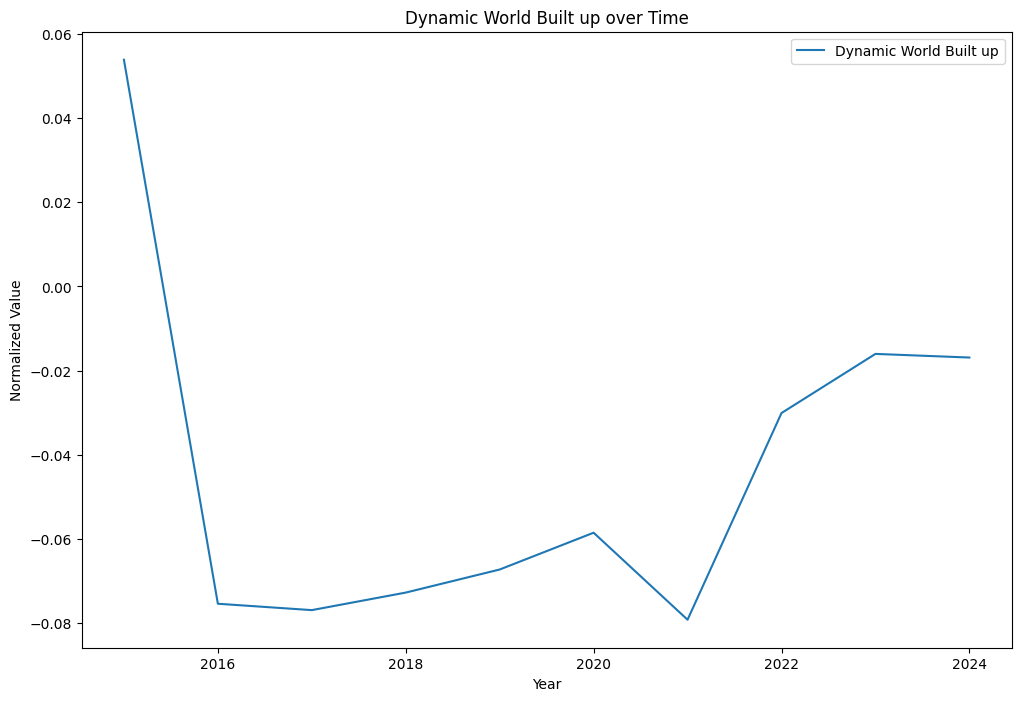

In [25]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas DataFrame for Seaborn plotting
df_built = pd.DataFrame({
    'Time': time_built,
    'Dynamic World Built up': built_
})

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time', y='Dynamic World Built up', data=df_built, label='Dynamic World Built up')

# Customize the plot
plt.title('Dynamic World Built up over Time')
plt.xlabel('Year')
plt.ylabel('Normalized Value')

plt.legend()
plt.show()

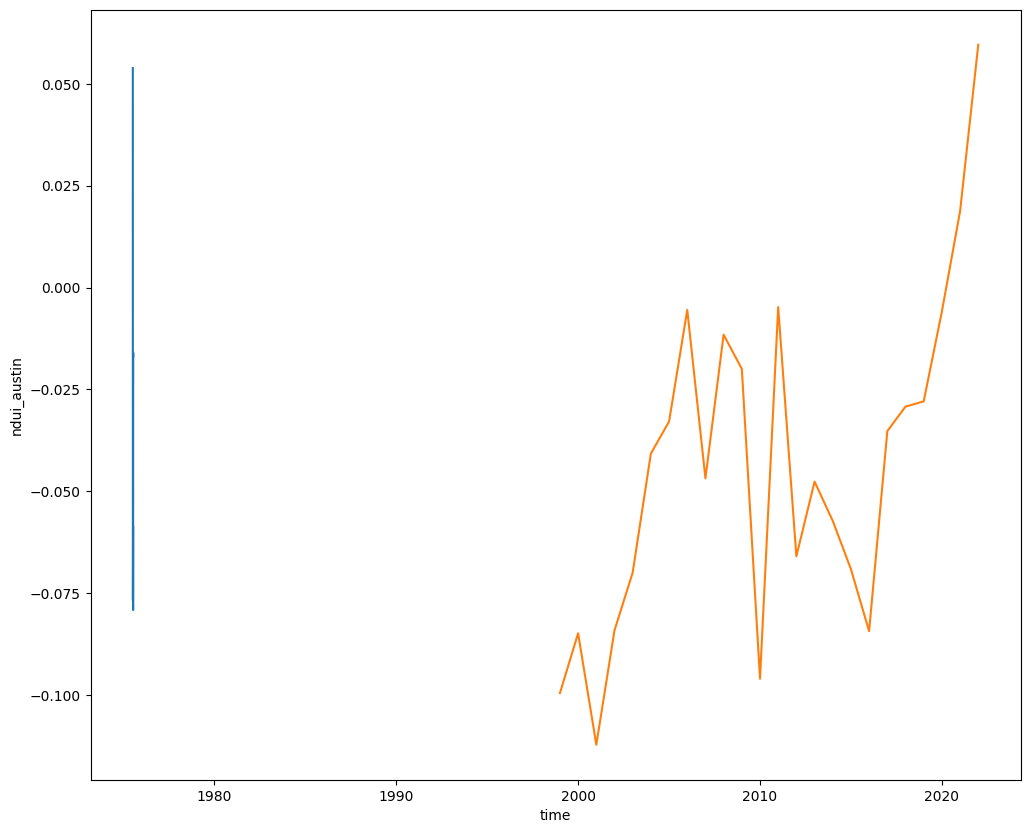

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))


built.plot(ax=ax, label='Dynamic World Built up')

du[1].ndui_austin.plot(ax=ax, label='NEXUS')

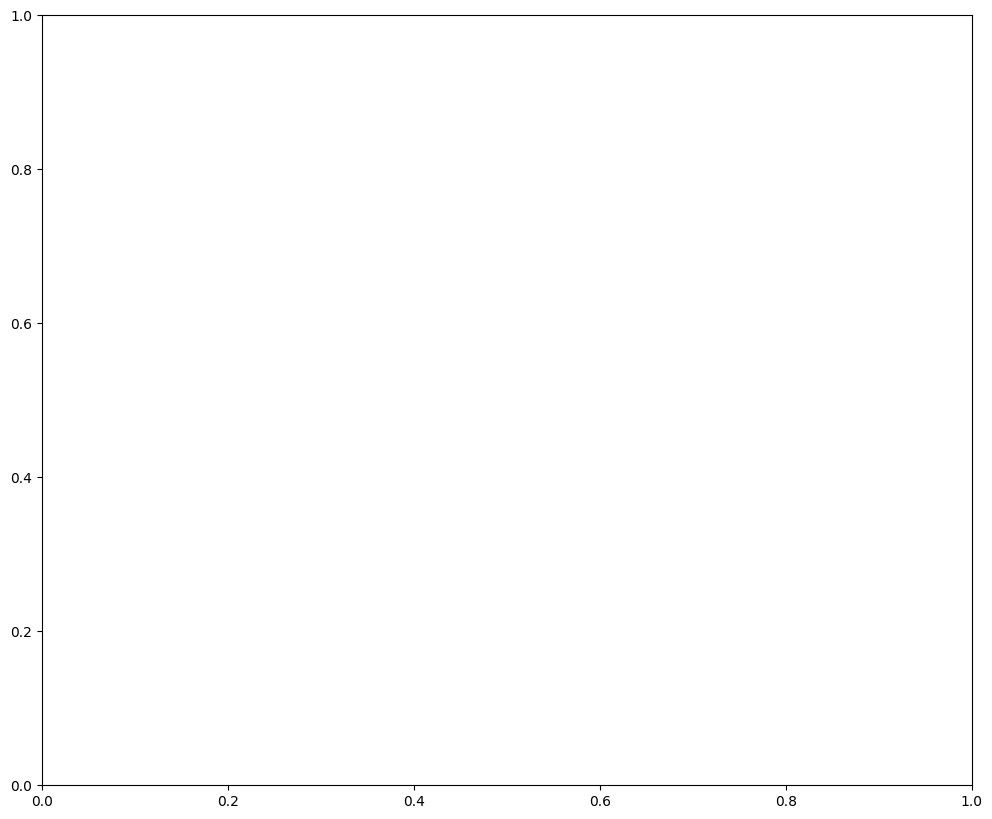

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))


AttributeError: 'DataArray' object has no attribute 'vl'

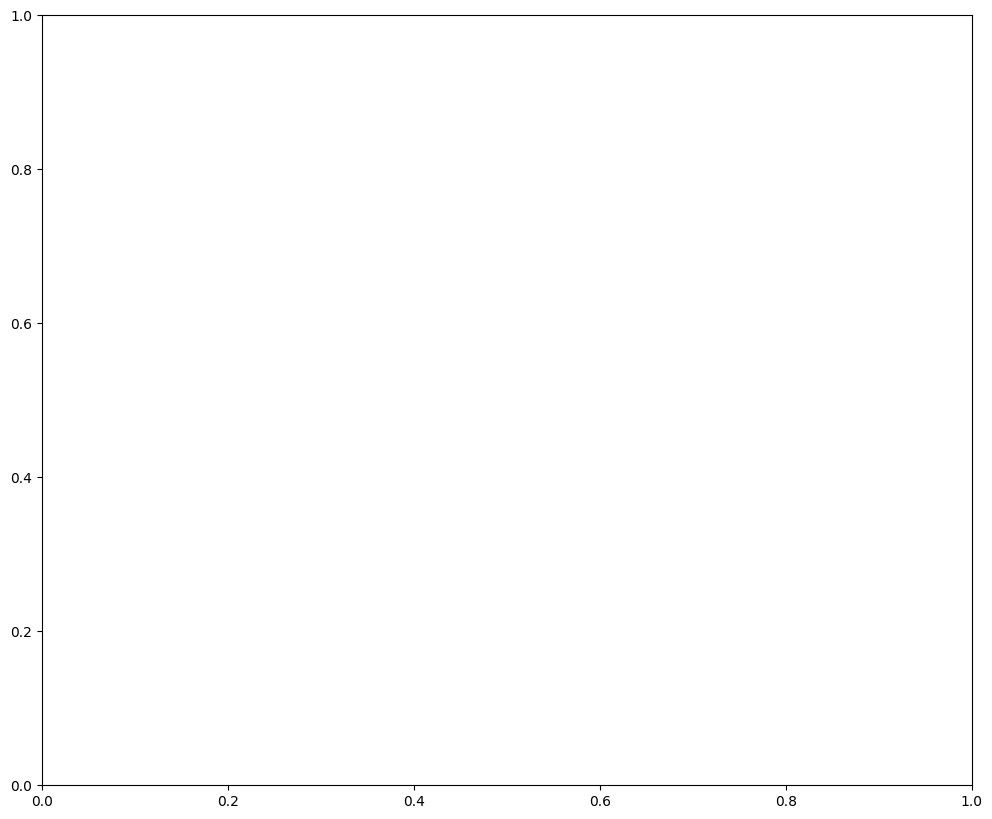

In [28]:
built = built.rename({'year': 'time'})

# Now you can proceed with the plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Normalize the 'built' data and plot
built_normalized = ((built - built.mean(dim='time')) / built.std(dim='time')) * du[1].ndui_austin.std(dim='time').vl + du[1].ndui_austin.mean(dim='time')
built_normalized.plot(ax=ax, label='Dynamic World Built up')

# Plot 'du[1].ndui_austin'
du[1].ndui_austin.plot(ax=ax, label='NEXUS')

# Add labels, title, and legend
ax.set_title('Comparison of Dynamic World Built up and NEXUS Data')
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')
ax.legend()

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Rename the 'year' coordinate in 'built' to 'time' so it matches with 'du[1].ndui_austin'
# built = built.rename({'year': 'time'})

# Normalize the 'built' data
built_normalized = ((built - built.mean(dim='time')) / built.std(dim='time')) * du[1].ndui_austin.std(dim='time') + du[1].ndui_austin.mean(dim='time')

# Convert the datasets to pandas DataFrames for Seaborn plotting
df_built = built_normalized.to_dataframe(name='Dynamic World Built up').reset_index()
df_nexus = du[1].ndui_austin.to_dataframe(name='NEXUS').reset_index()

# Combine the dataframes for easier plotting
df_combined = pd.merge(df_built, df_nexus, on='time')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='time', y='Dynamic World Built up', data=df_combined, label='Dynamic World Built up')
sns.lineplot(x='time', y='NEXUS', data=df_combined, label='NEXUS')

# Add labels, title, and legend
plt.title('Comparison of Dynamic World Built up and NEXUS Data')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()

plt.show()

In [ ]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc').mean(['x', 'y'])

# Perform the normalization and scaling
built = ((ds_built.built - ds_built.built.mean(dim='year'))/(ds_built.built.std(dim='year'))) * du[1].ndui_austin.std(dim='time') + du[1].ndui_austin.mean(dim='time')

# Extract the values and time coordinates for both datasets
built_ = built.values
time_built = ds_built.year.values

ndui_values = du[1].ndui_austin.values
time_ndui = du[1].time.values

# Convert to pandas DataFrames for Seaborn plotting
df_built = pd.DataFrame({
    'Time': time_built,
    'Dynamic World Built up': built_
})

df_ndui = pd.DataFrame({
    'Time': time_ndui,
    'NEXUS': ndui_values
})

# Merge the DataFrames on the 'Time' column
df_combined = pd.merge(df_built, df_ndui, on='Time', how='outer')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time', y='Dynamic World Built up', data=df_combined, label='Dynamic World Built up')
sns.lineplot(x='Time', y='NEXUS', data=df_combined, label='NEXUS')

# Customize the plot
plt.title('Comparison of Dynamic World Built up and NEXUS Data over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()

plt.show()

In [ ]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc').mean(['x', 'y'])

# Perform the normalization and scaling
built = ((ds_built.built - ds_built.built.mean(dim='year'))/(ds_built.built.std(dim='year'))) * du[1].ndui_austin.std(dim='time') + du[1].ndui_austin.mean(dim='time')

# Extract the values and time coordinates for both datasets
built_ = built.values
time_built = ds_built.year.values

ndui_values = du[1].ndui_austin.values
time_ndui = du[1].time.values

# Convert the time_built (which is int) to datetime format to match time_ndui
time_built = pd.to_datetime(time_built, format='%Y')

# Convert to pandas DataFrames for Seaborn plotting
df_built = pd.DataFrame({
    'Time': time_built,
    'Dynamic World Built up': built_
})

df_ndui = pd.DataFrame({
    'Time': time_ndui,
    'NEXUS': ndui_values
})

# Merge the DataFrames on the 'Time' column
df_combined = pd.merge(df_built, df_ndui, on='Time', how='outer')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Time', y='Dynamic World Built up', data=df_combined, label='Dynamic World Built up')
sns.lineplot(x='Time', y='NEXUS', data=df_combined, label='NEXUS')

# Customize the plot
plt.title('Comparison of Dynamic World Built up and NEXUS Data over Time')
plt.xlabel('Time')
plt.legend()

plt.show()

In [ ]:
ds_built

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc')

# Select the area around UT Austin
latitude = 30.2850
longitude = -97.7335

ds_built_selected = ds_built.built.mean(dim='year').sel(
    y=slice(latitude + 0.01, latitude - 0.01),
    x=slice(longitude - 0.01, longitude + 0.01)
)

# Plot the selected area
plt.figure(figsize=(10, 8))
ax = plt.gca()
ds_built_selected.plot(ax=ax, cmap='tab20c')

# Mark UT Austin Tower
plt.plot(-97.7353, 30.2861, 'ro', markersize=8)  # Approximate coordinates
plt.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=12)

# Mark the garden (LBJ Presidential Library Garden)
plt.plot(-97.7293, 30.2856, 'mo', markersize=8)  # Approximate coordinates
plt.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=12)

# Mark the stadium (Darrell K Royal–Texas Memorial Stadium)
plt.plot(-97.7320, 30.2838, 'go', markersize=8)  # Approximate coordinates
plt.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=12)
# Mark Hemphill Park
plt.plot(-97.739, 30.2935, 'go', markersize=8)  # Approximate coordinates
plt.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=12)

# Mark Oakwood Cemetery
plt.plot(-97.7255, 30.2761, 'ko', markersize=8)  # Approximate coordinates
plt.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=12)

plt.title('Mean Built-Up Area around UT Austin (2015-2024)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
!ls /content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc

In [ ]:
ds_ndui = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc')
ds_ndui

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
ds_ndui = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc')

# Select the area around UT Austin
latitude = 30.2850
longitude = -97.7335

ds_built_selected = ds_ndui.ndui.mean(dim='time').sel(
    lat=slice(latitude + 0.01, latitude - 0.01),
    lon=slice(longitude - 0.01, longitude + 0.01)
)

# Plot the selected area
plt.figure(figsize=(10, 8))
ax = plt.gca()
ds_built_selected.plot(ax=ax, cmap='tab20c')

# Mark UT Austin Tower
plt.plot(-97.7353, 30.2861, 'ro', markersize=8)  # Approximate coordinates
plt.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=12)

# Mark the garden (LBJ Presidential Library Garden)
plt.plot(-97.7293, 30.2856, 'mo', markersize=8)  # Approximate coordinates
plt.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=12)

# Mark the stadium (Darrell K Royal–Texas Memorial Stadium)
plt.plot(-97.7320, 30.2838, 'go', markersize=8)  # Approximate coordinates
plt.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=12)

# Mark Hemphill Park
plt.plot(-97.739, 30.2935, 'go', markersize=8)  # Approximate coordinates
plt.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=12)

# Mark Oakwood Cemetery
plt.plot(-97.7255, 30.2761, 'ko', markersize=8)  # Approximate coordinates
plt.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=12)

plt.title('Mean Built-Up Area around UT Austin (2015-2024)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

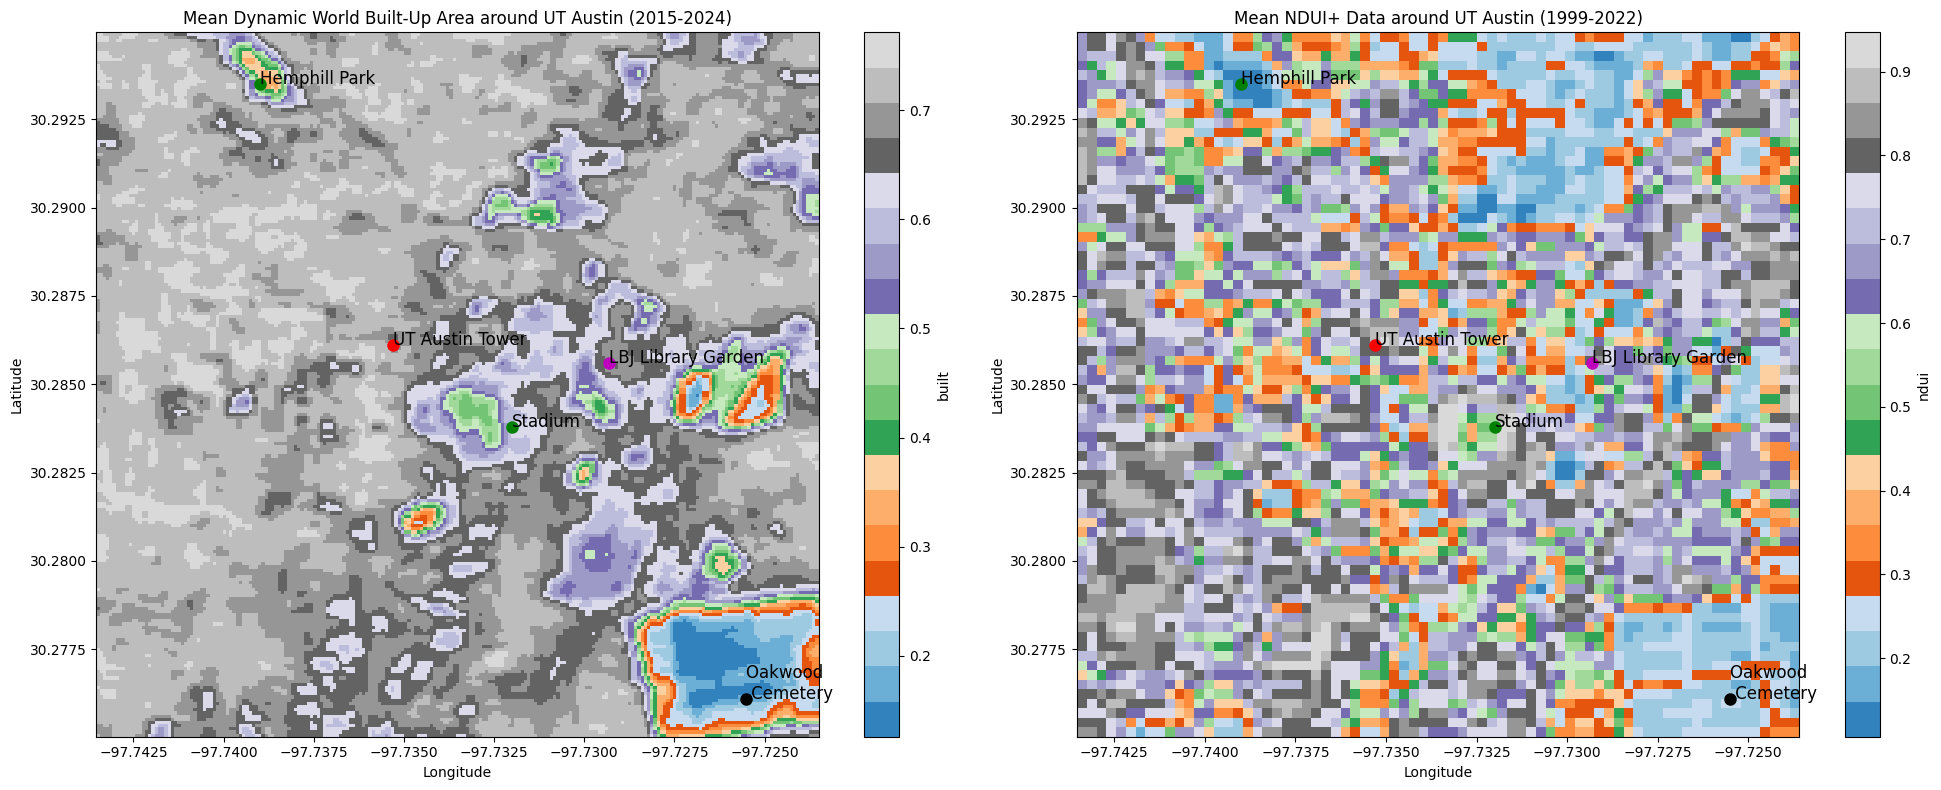

In [29]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the first dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc')

# Load the second dataset
ds_ndui = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc')

# Select the area around UT Austin for both datasets
latitude = 30.2850
longitude = -97.7335

ds_built_selected = ds_built.built.mean(dim='year').sel(
    y=slice(latitude + 0.01, latitude - 0.01),
    x=slice(longitude - 0.01, longitude + 0.01)
)

ds_ndui_selected = ds_ndui.ndui.mean(dim='time').sel(
    lat=slice(latitude + 0.01, latitude - 0.01),
    lon=slice(longitude - 0.01, longitude + 0.01)
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first selected area (Built-Up Area)
ds_built_selected.plot(ax=ax1, cmap='tab20c')
ax1.plot(-97.7353, 30.2861, 'ro', markersize=8)
ax1.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=12)
ax1.plot(-97.7293, 30.2856, 'mo', markersize=8)
ax1.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=12)
ax1.plot(-97.7320, 30.2838, 'go', markersize=8)
ax1.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=12)
ax1.plot(-97.739, 30.2935, 'go', markersize=8)
ax1.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=12)
ax1.plot(-97.7255, 30.2761, 'ko', markersize=8)
ax1.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=12)
ax1.set_title('Mean Dynamic World Built-Up Area around UT Austin (2015-2024)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plot the second selected area (NDUI Data)
ds_ndui_selected.plot(ax=ax2, cmap='tab20c')
ax2.plot(-97.7353, 30.2861, 'ro', markersize=8)
ax2.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=12)
ax2.plot(-97.7293, 30.2856, 'mo', markersize=8)
ax2.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=12)
ax2.plot(-97.7320, 30.2838, 'go', markersize=8)
ax2.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=12)
ax2.plot(-97.739, 30.2935, 'go', markersize=8)
ax2.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=12)
ax2.plot(-97.7255, 30.2761, 'ko', markersize=8)
ax2.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=12)
ax2.set_title('Mean NDUI+ Data around UT Austin (1999-2022)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.savefig('dynamic_world_validation.png', dpi=500)

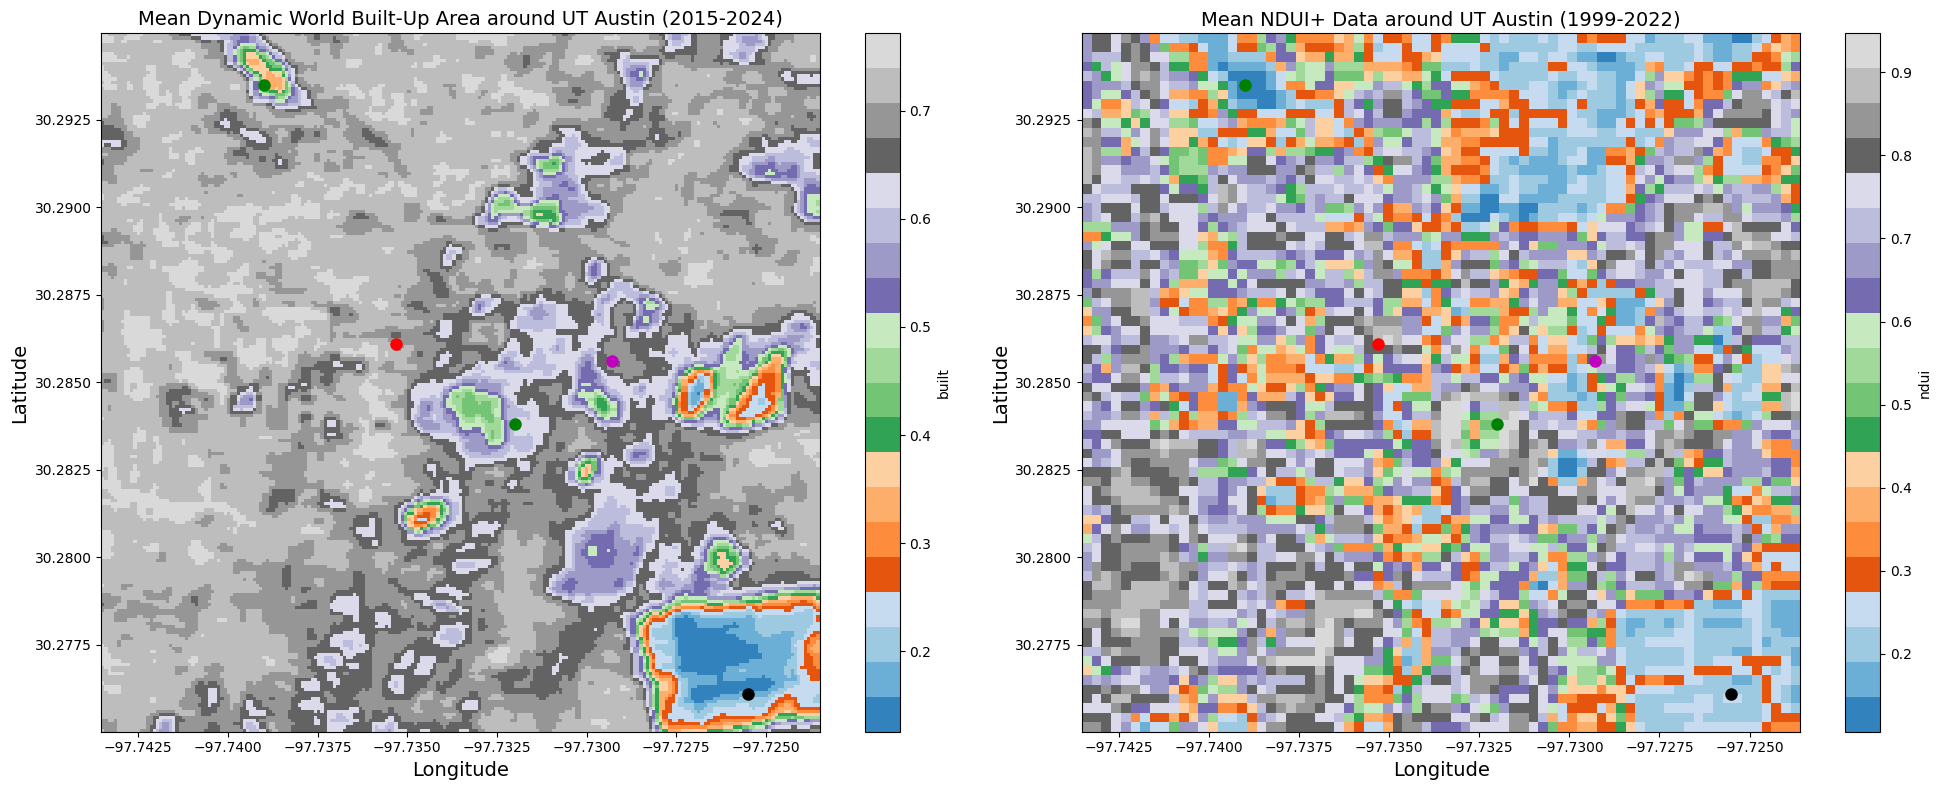

In [33]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the first dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc')

# Load the second dataset
ds_ndui = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc')

# Select the area around UT Austin for both datasets
latitude = 30.2850
longitude = -97.7335

ds_built_selected = ds_built.built.mean(dim='year').sel(
    y=slice(latitude + 0.01, latitude - 0.01),
    x=slice(longitude - 0.01, longitude + 0.01)
)

ds_ndui_selected = ds_ndui.ndui.mean(dim='time').sel(
    lat=slice(latitude + 0.01, latitude - 0.01),
    lon=slice(longitude - 0.01, longitude + 0.01)
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first selected area (Built-Up Area)
ds_built_selected.plot(ax=ax1, cmap='tab20c', add_colorbar=True)
ax1.plot(-97.7353, 30.2861, 'ro', markersize=8)
ax1.plot(-97.7293, 30.2856, 'mo', markersize=8)
ax1.plot(-97.7320, 30.2838, 'go', markersize=8)
ax1.plot(-97.739, 30.2935, 'go', markersize=8)
ax1.plot(-97.7255, 30.2761, 'ko', markersize=8)
ax1.set_title('Mean Dynamic World Built-Up Area around UT Austin (2015-2024)', fontsize=14)
ax1.set_xlabel('Longitude', fontsize=14)
ax1.set_ylabel('Latitude', fontsize=14)

# Plot the second selected area (NDUI Data)
ds_ndui_selected.plot(ax=ax2, cmap='tab20c', add_colorbar=True)
ax2.plot(-97.7353, 30.2861, 'ro', markersize=8)
ax2.plot(-97.7293, 30.2856, 'mo', markersize=8)
ax2.plot(-97.7320, 30.2838, 'go', markersize=8)
ax2.plot(-97.739, 30.2935, 'go', markersize=8)
ax2.plot(-97.7255, 30.2761, 'ko', markersize=8)
ax2.set_title('Mean NDUI+ Data around UT Austin (1999-2022)', fontsize=14)
ax2.set_xlabel('Longitude', fontsize=14)
ax2.set_ylabel('Latitude', fontsize=14)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig('dynamic_world_validation.png', dpi=500)

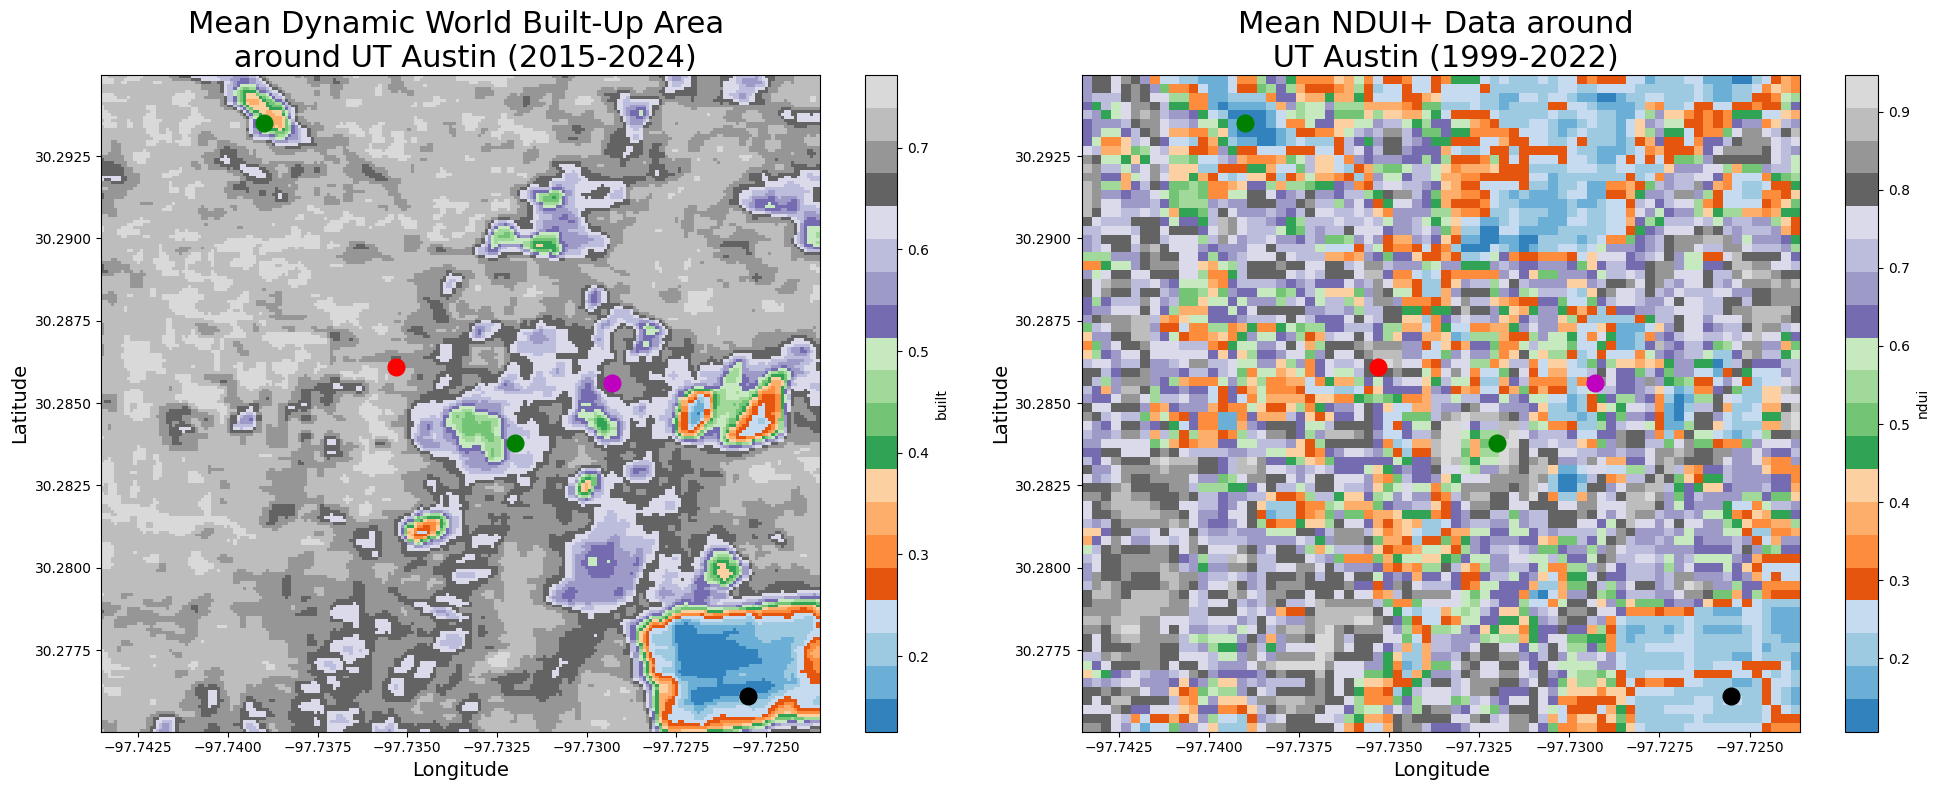

In [35]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the first dataset
ds_built = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc')

# Load the second dataset
ds_ndui = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc')

# Select the area around UT Austin for both datasets
latitude = 30.2850
longitude = -97.7335

ds_built_selected = ds_built.built.mean(dim='year').sel(
    y=slice(latitude + 0.01, latitude - 0.01),
    x=slice(longitude - 0.01, longitude + 0.01)
)

ds_ndui_selected = ds_ndui.ndui.mean(dim='time').sel(
    lat=slice(latitude + 0.01, latitude - 0.01),
    lon=slice(longitude - 0.01, longitude + 0.01)
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Increase font size for labels and title
font_size = 16
label_size = 14
title_size = 22

# Plot the first selected area (Built-Up Area)
ds_built_selected.plot(ax=ax1, cmap='tab20c')
ax1.plot(-97.7353, 30.2861, 'ro', markersize=12)
# ax1.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=font_size)
ax1.plot(-97.7293, 30.2856, 'mo', markersize=12)
# ax1.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=font_size)
ax1.plot(-97.7320, 30.2838, 'go', markersize=12)
# ax1.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=font_size)
ax1.plot(-97.739, 30.2935, 'go', markersize=12)
# ax1.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=font_size)
ax1.plot(-97.7255, 30.2761, 'ko', markersize=12)
# ax1.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=font_size)
ax1.set_title('Mean Dynamic World Built-Up Area \n around UT Austin (2015-2024)', fontsize=title_size)
ax1.set_xlabel('Longitude', fontsize=label_size)
ax1.set_ylabel('Latitude', fontsize=label_size)

# Plot the second selected area (NDUI Data)
ds_ndui_selected.plot(ax=ax2, cmap='tab20c')
ax2.plot(-97.7353, 30.2861, 'ro', markersize=12)
# ax2.text(-97.7353, 30.2861, 'UT Austin Tower', color='black', fontsize=font_size)
ax2.plot(-97.7293, 30.2856, 'mo', markersize=12)
# ax2.text(-97.7293, 30.2856, 'LBJ Library Garden', color='black', fontsize=font_size)
ax2.plot(-97.7320, 30.2838, 'go', markersize=12)
# ax2.text(-97.7320, 30.2838, 'Stadium', color='black', fontsize=font_size)
ax2.plot(-97.739, 30.2935, 'go', markersize=12)
# ax2.text(-97.739, 30.2935, 'Hemphill Park', color='black', fontsize=font_size)
ax2.plot(-97.7255, 30.2761, 'ko', markersize=12)
# ax2.text(-97.7255, 30.2761, 'Oakwood \n Cemetery', color='black', fontsize=font_size)
ax2.set_title('Mean NDUI+ Data around \n UT Austin (1999-2022)', fontsize=title_size)
ax2.set_xlabel('Longitude', fontsize=label_size)
ax2.set_ylabel('Latitude', fontsize=label_size)

plt.tight_layout()
plt.savefig('dynamic_world_validation.png', dpi=500)

# Urban expansion in Austin

In [ ]:
!ls /content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc

In [ ]:
import xarray as xr
ds_austin = xr.open_dataset('/content/drive/MyDrive/long_ndui/austin/ndui_austin_1999_2022.nc').sel(time=slice('2015-01-01', '2022-12-31'))
ds_austin

In [ ]:
!ls /content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc

In [ ]:
ds_austin

In [ ]:
ds_austin.ndui.isel(time=0).plot()

In [ ]:
ds_built_up = xr.open_dataset('/content/drive/MyDrive/earth_engine/dynamic_world_built_2015_2024.nc').sel(year=slice(2015, 2022))
ds_built_up

In [ ]:
ds_built_up_interp = ds_built_up.interp(
    x=ds_austin.lon.values,
    y=ds_austin.lat.values
)

In [ ]:
ds_built_up_interp

In [ ]:
ds_austin['built_up_dw'] = (('time', 'lat', 'lon'), ds_built_up_interp.built.values)
ds_austin

In [ ]:
ds_austin.built_up_dw.isel(time=2).sel(lon=slice(-97.8,-97.6)).sel(lat=slice(30.36,30.17)).plot()

In [ ]:
ds_austin_small = ds_austin.sel(lon=slice(-97.8,-97.6)).sel(lat=slice(30.36,30.17))
ds_austin_small

In [ ]:
ds_austin_small['built_mask'] =  ds_austin_small.built_up_dw > 0.2
ds_austin_small['ndui_filtered'] = ds_austin_small.ndui * ds_austin_small.built_mask

# 2016, 2018, 2020, 2022

In [ ]:
ds_austin_small.ndui_filtered.isel(time=7).plot()

In [ ]:
ds_austin_small.ndui_filtered.isel(time=7).plot(cmap='gist_stern_r',vmin=0, vmax=1, extend='max')

In [ ]:
ds_austin_small.ndui_filtered.isel(time=7).mean().values

In [ ]:
ds_austin_small.ndui_filtered.isel(time=1).mean()

In [ ]:
# Run once
# !pip install rasterio netCDF4 wxee timm cartopy osmnx xarray pyresample
# !apt-get install -y gdal-bin
# !pip install gdal

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import matplotlib.patheffects as PathEffects

# Mock the dataset and mean values for plotting (this is because I don't have access to your specific dataset)
time_steps = [1, 3, 5, 7]
mean_ndui_values = [ds_austin_small.ndui_filtered.isel(time=1).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=3).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=5).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=7).mean().values]  # Example means for each timestep
years = ['2016', '2018', '2020', '2022']  # Example years for each timestep

# Setup for Austin, Texas, and roads
city_name = 'Austin, Texas, USA'
tags = {'highway': True}  # Retrieves all highway types

# Get the road network within Austin
road_network = ox.graph_from_place(city_name, network_type='all')

# Convert road network to GeoDataFrame
road_edges = ox.graph_to_gdfs(road_network, nodes=False, edges=True)

# Filter for major roads (primary, secondary, tertiary)
major_road_types = ['primary', 'secondary', 'tertiary']
major_roads = road_edges[road_edges['highway'].isin(major_road_types)]

# Important locations to plot (using arbitrary coordinates as placeholders)
locations = {
    "Downtown": (-97.7431, 30.2672),   # Longitude, Latitude of Downtown Austin
    "UT Austin": (-97.7356, 30.2849),  # University of Texas Austin
    "Airport": (-97.6663, 30.2020),    # Austin-Bergstrom International Airport
    "Zilker Park": (-97.7725, 30.2669) # Zilker Metropolitan Park
}

In [ ]:
# Important locations to plot (using arbitrary coordinates as placeholders)
locations = {
  # Longitude, Latitude of Downtown Austin
    "UT Austin": (-97.7356, 30.2849),  # University of Texas Austin
    "Airport": (-97.6663, 30.2020),    # Austin-Bergstrom International Airport
    "Zilker Park": (-97.7725, 30.2669) # Zilker Metropolitan Park
}

In [ ]:
# Start plotting
import matplotlib.patheffects as PathEffects
years = ['2016', '2018', '2020', '2022']
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
fig.suptitle('Urban Expansion in Austin using NDUI+', fontsize=16)
cnt = 1
for i, (ax, time, mean_val, year) in enumerate(zip(axes.flat, time_steps, mean_ndui_values, years)):

    major_roads.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.7)

    ds_austin_small.ndui_filtered.isel(time=cnt).plot(cmap='gist_stern_r', vmin=0, vmax=1, ax=ax, extend='max')
    # Overlay major roads


    # Mark important locations
    for location, coords in locations.items():
        # ax.plot(coords[0], coords[1], 'bx')  # Plot points
        # ax.text(coords[0] + 0.01, coords[1], location, fontsize=12, color='black')
        ax.plot(coords[0], coords[1], 'bx', markersize=10)  # Plot black 'x' marker

        # Add text with white outline for visibility
        text = ax.text(coords[0] + 0.01, coords[1], location, fontsize=12, color='black',
                       path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")])


    ax.set_title(f'{year} (Mean NDUI+ {mean_val:.2f})')
    cnt=cnt+2
# Show plot
plt.tight_layout()
plt.savefig('urban_expansion.png')

In [ ]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# Define the locations and their coordinates with numbers for labeling
locations = {
    1: ("Downtown", (-97.7431, 30.2672)),    # Longitude, Latitude of Downtown Austin
    2: ("UT Austin", (-97.7356, 30.2849)),   # University of Texas Austin
    3: ("Airport", (-97.6663, 30.2020)),     # Austin-Bergstrom International Airport
    4: ("Zilker Park", (-97.7725, 30.2669))  # Zilker Metropolitan Park
}

# Define years and mock mean NDUI+ values
years = ['2016', '2018', '2020', '2022']
time_steps = [1, 3, 5, 7]
mean_ndui_values = [ds_austin_small.ndui_filtered.isel(time=1).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=3).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=5).mean().values, \
                    ds_austin_small.ndui_filtered.isel(time=7).mean().values]   # Example mean NDUI+ values

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
fig.suptitle('Urban Expansion in Austin using NDUI+', fontsize=16)

cnt = 1
for i, (ax, time, mean_val, year) in enumerate(zip(axes.flat, time_steps, mean_ndui_values, years)):
    # Plot major roads
    major_roads.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5)

    # Plot NDUI+ data (replace with your actual data plot)
    ds_austin_small.ndui_filtered.isel(time=cnt).plot(cmap='gist_stern_r', vmin=0, vmax=1, ax=ax, extend='max')

    ax.set_title(f'{year} (Mean NDUI+ {mean_val:.2f})')

    cnt += 2
    # # Mark important locations with numbers instead of names
for num, (location, coords) in locations.items():
    # Plot numbered markers with black 'x' for the location
    axes[0,1].plot(coords[0], coords[1], 'bx', markersize=10)

    # Add the number instead of text label, with a white outline for visibility
    axes[0,1].text(coords[0], coords[1], str(num), fontsize=9, color='black', ha='center', va='center',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")])

# # Create a custom legend mapping numbers to location names
legend_labels = [f'{num}: {location}' for num, (location, _) in locations.items()]
legend_handles = [plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='b', markersize=10, label=label)
                  for label in legend_labels]

# Add the legend to the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=2, fontsize=12)

# Adjust layout and save the plot
plt.tight_layout()  # Adjust for space for the legend
plt.savefig('urban_expansion.png')

In [ ]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# Define the locations and their coordinates with numbers for labeling
locations = {
    1: ("Downtown", (-97.7431, 30.2672)),    # Longitude, Latitude of Downtown Austin
    2: ("UT Austin", (-97.7356, 30.2849)),   # University of Texas Austin
    3: ("Airport", (-97.6663, 30.2020)),     # Austin-Bergstrom International Airport
    4: ("Zilker Park", (-97.7725, 30.2669))  # Zilker Metropolitan Park
}

# Define years and actual mean NDUI+ values from the dataset
years = ['2016', '2018', '2020', '2022']
time_steps = [1, 3, 5, 7]
mean_ndui_values = [ds_austin_small.ndui_filtered.isel(time=1).mean().values,
                    ds_austin_small.ndui_filtered.isel(time=3).mean().values,
                    ds_austin_small.ndui_filtered.isel(time=5).mean().values,
                    ds_austin_small.ndui_filtered.isel(time=7).mean().values]

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
fig.suptitle('Urban Expansion in Austin using NDUI+', fontsize=16)

cnt = 1
for i, (ax, time, mean_val, year) in enumerate(zip(axes.flat, time_steps, mean_ndui_values, years)):
    # Plot major roads
    major_roads.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5)

    # Plot NDUI+ data
    ds_austin_small.ndui_filtered.isel(time=cnt).plot(cmap='gist_stern_r', vmin=0, vmax=1, ax=ax, extend='max')

    ax.set_title(f'{year} (Mean NDUI+ {mean_val:.2f})')
    cnt += 2

# Mark important locations with numbers instead of names
for num, (location, coords) in locations.items():
    # Plot numbered markers with black 'x' for the location
    axes[0, 1].plot(coords[0], coords[1], 'bx', markersize=10)

    # Add the number with a white outline for visibility
    axes[0, 1].text(coords[0], coords[1], str(num), fontsize=9, color='black', ha='center', va='center',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")])

# Create a custom legend mapping numbers to location names
legend_labels = [f'{num}: {location}' for num, (location, _) in locations.items()]
legend_handles = [plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='b', markersize=10, label=label)
                  for label in legend_labels]

# Add the legend to the figure with a slight lower position
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=2, fontsize=12)

# Adjust layout and save the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the lowered legend
plt.savefig('urban_expansion.png')

In [ ]:
ds_austin_small['ndui_change'] = ((ds_austin_small.ndui_filtered - ds_austin_small.ndui_filtered.isel(time=1)) / ds_austin_small.ndui_filtered.isel(time=1))*100
ds_austin_small

In [ ]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# Define the locations and their coordinates with numbers for labeling
locations = {
    1: ("Downtown", (-97.7431, 30.2672)),    # Longitude, Latitude of Downtown Austin
    2: ("UT Austin", (-97.7356, 30.2849)),   # University of Texas Austin
    3: ("Airport", (-97.6663, 30.2020)),     # Austin-Bergstrom International Airport
    4: ("Zilker Park", (-97.7725, 30.2669))  # Zilker Metropolitan Park
}
ds_plot = [ds_austin_small.ndui_filtered.isel(time=1), \
           ds_austin_small['ndui_change'].isel(time=3), \
           ds_austin_small['ndui_change'].isel(time=5), \
           ds_austin_small['ndui_change'].isel(time=7)]
# Define years and actual mean NDUI+ values from the dataset
years = ['2016', '2018', '2020', '2022']
time_steps = [1, 3, 5, 7]
mean_ndui_values = [ds_austin_small.ndui_filtered.isel(time=1).mean().values,
                    np.mean((ds_plot[1].values[np.isfinite(ds_plot[2].values)])),
                    np.mean((ds_plot[2].values[np.isfinite(ds_plot[2].values)])),
                    np.mean((ds_plot[3].values[np.isfinite(ds_plot[3].values)]))]

# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
fig.suptitle('Urban Expansion in Austin using NDUI+', fontsize=16)

im = ds_plot[0].plot(ax=ax[0,0], cmap='gist_stern_r', vmin=0, vmax=1, extend='max')
im.colorbar.set_label('')
im = ds_plot[1].plot(ax=ax[0,1], vmin=0, vmax=100, extend='max', cmap='Reds', label='%')
im.colorbar.set_label('%')
im = ds_plot[2].plot(ax=ax[1,0], vmin=0, vmax=100, extend='max', cmap='Reds')
im.colorbar.set_label('%')
im = ds_plot[3].plot(ax=ax[1,1], vmin=0, vmax=100, extend='max', cmap='Reds')
im.colorbar.set_label('%')

cnt = 0
# #for i, (ax, time, mean_val, year) in enumerate(zip(axes.flat, time_steps, mean_ndui_values, years)):
for i in range(2):
    for j in range(2):
        # Plot major roads
        major_roads.plot(ax=ax[i,j], edgecolor='black', linewidth=0.5, alpha=0.5)

#         # Plot NDUI+ data
#         #ds_austin_small.ndui_filtered.isel(time=cnt).plot(cmap='gist_stern_r', vmin=0, vmax=1, ax=ax, extend='max')
#         ds_plot[cnt].plot(ax=ax[i,j])
        if i==0 and j==0:
            ax[i,j].set_title(f'{years[cnt]} (Mean NDUI+ {mean_ndui_values[cnt]:.2f})')
        else:
            ax[i,j].set_title(f'{years[cnt]} (Mean change in NDUI+ {mean_ndui_values[cnt]:.2f}'+' %)')
        cnt += 1

# # Mark important locations with numbers instead of names
for num, (location, coords) in locations.items():
    # Plot numbered markers with black 'x' for the location
    #ax[0, 1].plot(coords[0], coords[1], 'bx', markersize=10)

    # Add the number with a white outline for visibility
    ax[0, 1].text(coords[0], coords[1], str(num), fontsize=9, color='black', ha='center', va='center',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="white")])

# # Create a custom legend mapping numbers to location names
legend_labels = [f'{num}: {location}' for num, (location, _) in locations.items()]
legend_handles = [plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='b', markersize=10, label=label)
                  for label in legend_labels]

# # Add the legend to the figure with a slight lower position
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=2, fontsize=12)

# # Adjust layout and save the plot
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make room for the lowered legend
plt.savefig('urban_expansion_percent.png')

In [ ]:
np.mean((ds_plot[3].values[np.isfinite(ds_plot[3].values)]))